# Assignment 1 Diabetes Dataset and AutoML

### Dataset background

**Acknowledgements**  
<br> 
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). [Using the ADAP learning algorithm to forecast the onset of diabetes mellitus](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2245318/pdf/procascamc00018-0276.pdf). In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.


The dataset can be found [here](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database).    
</br>    

The data was collected in the hopes of creating an algorithm which is able to forecast if someone will develop diabetes within five years.  
The study started in 1965 and collected data from Pima Indian women in Phoenix, Arizona and surrounding areas.  
The authors of the paper picked 8 suitable features that they believed would best help to forecast the likelihood of diabetes. I will explore these features in greater detail throughout this notebook.


### The goal for this assignment

For this assignment, I plan on comparing various algorithms on the diabetes dataset. I will follow similar steps taken in the research paper while also exploring new techniques.   
The main objective of this assignment is to compare the results achieved from the "Decision Tree" algorithm and the PyCaret library.  
To compare the results I will use the two metrics, accuracy and F1-score. 
I choose accuracy because this shows an overall picture of how the algorithm is doing but since the distribution of the target values isn't balanced I also choose the F1 score. Since this takes the unbalanced distribution into account. 

### The layout of the notebook

1. [Import Python Libraries](#Import-Python-Libraries)
2. [Functions](#Functions)
3. [Data Visualization](#Data-Visualization)
4. [Data Preperation](#Data-Preperation)
    1. [Import Data](Import-Data)
    2. [Split Data Into Train and Test Sets](#Split-Data-Into-Train-and-Test-Sets)
    3. [Preprocess Data](#Preprocess-Data)
        1. [Impute Missing Values Using Averages](#Impute-Missing-Values-Using-Averages)
4. [Random Forest classifier](#Random-Forest-classifier)
5. [Automated ML method via PyCaret](#Automated-ML-method-via-PyCaret)
6. [Exploring Other Models](#Exploring-Other-Models)
  1. [Ensemble Results](#Ensemble-Resulst)
7. [Comparing Results](#Comparing-Results)


## Import Python Libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (24,16)
import seaborn as sns
color_palette = "tab10"

import sklearn
from sklearn import preprocessing, ensemble
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import lightgbm as lgb

import warnings
from pycaret.classification import *
from pycaret.utils import enable_colab
enable_colab()
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import logging, sys
logging.disable(sys.maxsize)

Colab mode enabled.


## Functions

In [ ]:
def plot_columns(X, y, hue="Outcome"):
  """ 
  This function is used to plot a histogram of all the columns and show the distribution of values relative to the feature "hue".

  Input parameters:

  X: The feature columns of the dataset
  y: The target values of the dataset
  hue: What feature to highlight in the histograms

  Output:

  Plots an NxN size subgraph of histograms 
  """


  full_trainset = X.join(y)
  data_colNames = full_trainset.columns

  numRows = int(np.ceil(np.sqrt(len(data_colNames))))

  fig, axes = plt.subplots(numRows, numRows, figsize=(24,16))

  fig.suptitle(f"Histogram of all the features, split by {hue}")
  for i in range(numRows): 
    for j in range(numRows):
      count = (i*3) + j
      sns.histplot(ax=axes[i, j], data=full_trainset, x=data_colNames[count], hue=hue)

In [ ]:
def find_best_model(X, y, kf, model, parameters):
    """ 
    This function is used to return the best model found using grid search and cross validation.
    
    The inputs are:
    X: The features
    y: The target value
    kf: The input for the cross validation used in the GridSearchCV function
    
    The output is:
    best_model: The model I will use to predict the y_test (test target) values.
    """
    if not kf:
      search = GridSearchCV(estimator = model, param_grid = parameters, scoring='f1_macro', cv=10, refit=True)
    else:
      search = GridSearchCV(estimator = model, param_grid = parameters, scoring='f1_macro',cv = kf, refit=True)
    result = search.fit(X, y)
    
    best_model = result.best_estimator_
    
    return best_model

def find_and_print_results(X_train, X_test, y_train, y_test, best_model, return_results=True):
    
    """ 
    This function is used to predict and print the accuracy, F1-score and confusion matrix of
    the target values using the "best model" found.
 
    The inputs are:
    X_train: The features for the train set
    X_test:  The features for the test set
    y_train: The target value for the train set
    y_test: The target value for the test set
    best_model: The model found using cross-validation on the train set.
    return_results: [True or False], if I want the function to return the predicted values for the train and test sets.
    
    The outputs are:
    pred_train: The predicated values found using the features and the best_model
    pred_test: The predicated values found using the features and the best_model
    """
    pred_train = best_model.predict(X_train)
    pred_test = best_model.predict(X_test)

    print_results(y_train, pred_train, y_test, pred_test)
    
    if return_results:
      return pred_train, pred_test

def print_results(y_train, pred_train, y_test, pred_test):
    print("Train set results")
    print("Confusion matrix:")
    print(confusion_matrix(y_train, pred_train), end='\n\n')
    print(f"The accuracy score is: {accuracy_score(y_train, pred_train):.2f}")
    print(f"The f1 score is: {f1_score(y_train, pred_train):.2f}", end='\n\n')
    print("Test set results")
    print("Confusion matrix:")
    print(confusion_matrix(y_test, pred_test), end='\n\n')
    print(f"The accuracy score is: {accuracy_score(y_test, pred_test):.2f}")
    print(f"The f1 score is: {f1_score(y_test, pred_test):.2f}")

In [ ]:
def plot_feature_importances(colNames,model):
  """ 
  ....
  """
  
  importances = model.feature_importances_
  indices = np.argsort(importances)

  plt.title('Feature Importances')
  plt.barh(range(len(indices)), importances[indices], color='b', align='center')
  plt.yticks(range(len(indices)), [colNames[i] for i in indices])
  plt.xlabel('Relative Importance')
  plt.show()

In [ ]:
def ensemble_results(model_dict):
  number_of_models = len(model_dict)
  train_size = len(model_dict["RandomForest"])
  y_hat = [0] * train_size
  for key in model_dict:
    for i in range(train_size):
      y_hat[i] += model_dict[key][i]

  return y_hat

## Data Preperation

### Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/diabetes.csv"
data = pd.read_csv(path)
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

### Split Data Into Train, Validation and Test Sets

In [ ]:
# The target size for each set, (The same split size as the orginal paper)
train_size = 0.75
test_size = 0.25
random_state = 1

# Split the data into features (X) and the target (y)
X, y = data.drop(columns=["Outcome"]), data[["Outcome"]]

# Split into train_validation set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [ ]:
print(f"Size of Train set {len(X_train)}, as a percentage {100 * len(X_train)/len(X):.2f}%")
print(f"Size of Test set {len(X_test)}, as a percentage {100 * len(X_test)/len(X):.2f}%")

Size of Train set 576, as a percentage 75.00%
Size of Test set 192, as a percentage 25.00%


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576 entries, 118 to 37
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               576 non-null    int64  
 1   Glucose                   576 non-null    int64  
 2   BloodPressure             576 non-null    int64  
 3   SkinThickness             576 non-null    int64  
 4   Insulin                   576 non-null    int64  
 5   BMI                       576 non-null    float64
 6   DiabetesPedigreeFunction  576 non-null    float64
 7   Age                       576 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 40.5 KB


At first look it seems that there are no null or missing values in the dataset.

In [ ]:
X_train.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   576.000000  576.000000     576.000000     576.000000  576.000000   
mean      3.782986  121.034722      68.800347      19.777778   77.006944   
std       3.362678   31.203715      20.053582      15.878208  110.978995   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000  100.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      22.000000    0.000000   
75%       6.000000  141.000000      80.000000      32.000000  122.750000   
max      15.000000  198.000000     122.000000      99.000000  744.000000   

              BMI  DiabetesPedigreeFunction         Age  
count  576.000000                576.000000  576.000000  
mean    31.781944                  0.467835   33.138889  
std      7.552579                  0.331290   11.805149  
min      0.000000                  0.085000   21.000000  
25%     26.800000                  0.245000   24.000000  
50%     31.600000                  0.363000   29.000000  
75%     36.225000                  0.600250   40.000000  
max     67.100000                  2.329000   72.000000

### Data Visualization

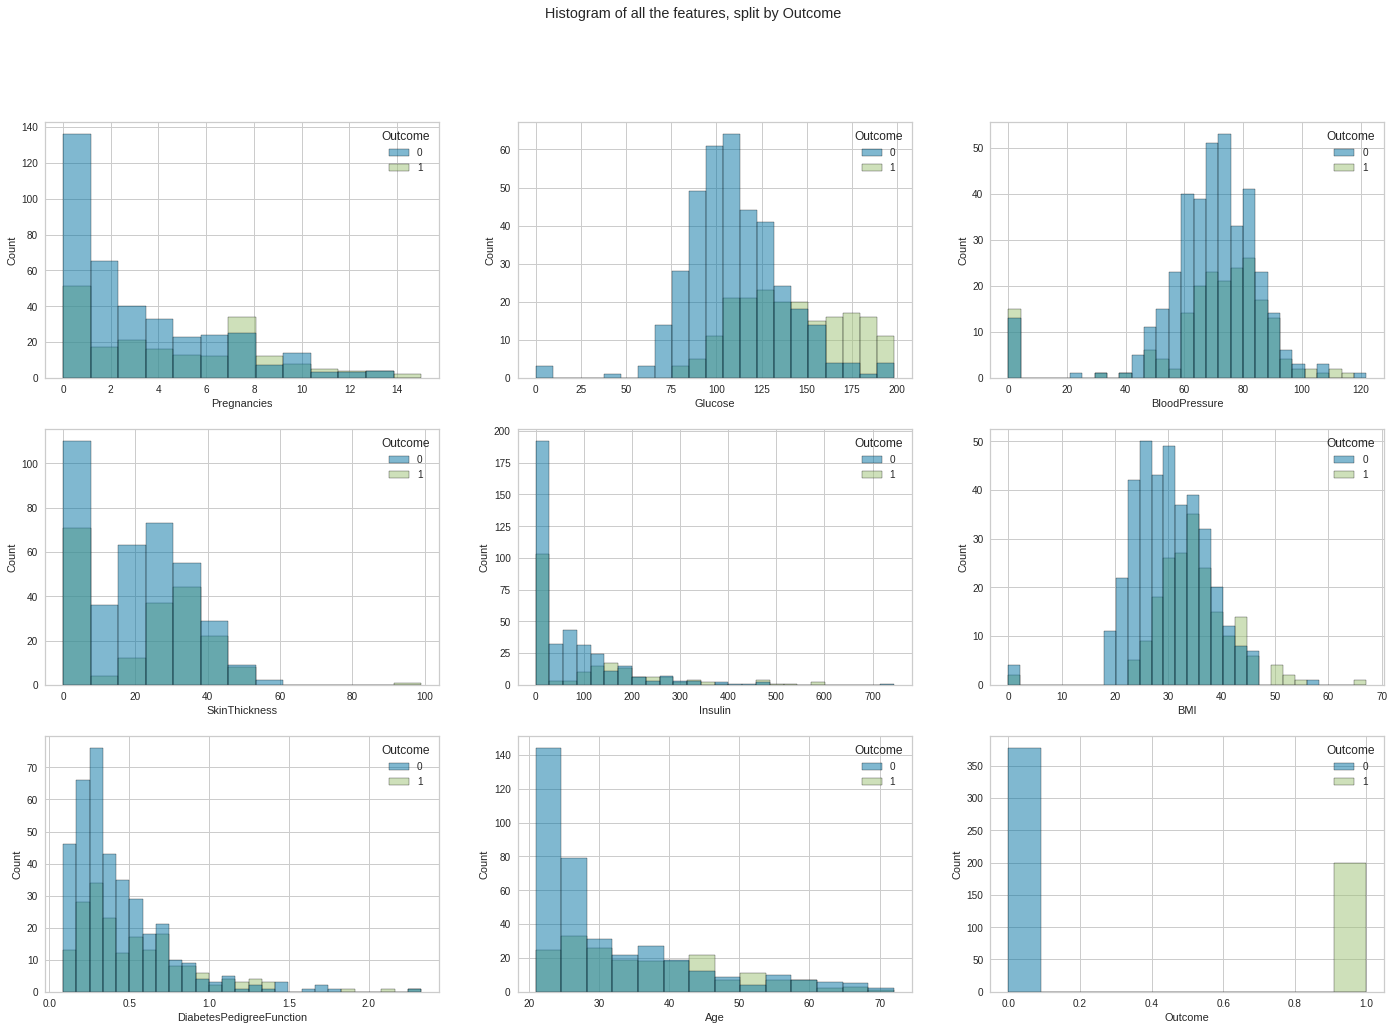

In [ ]:
plot_columns(X_train, y_train, hue="Outcome")

By looking at the distribution of values for the features I see no clear threshold for the target values.  
I will explore the relationship of features with each other.


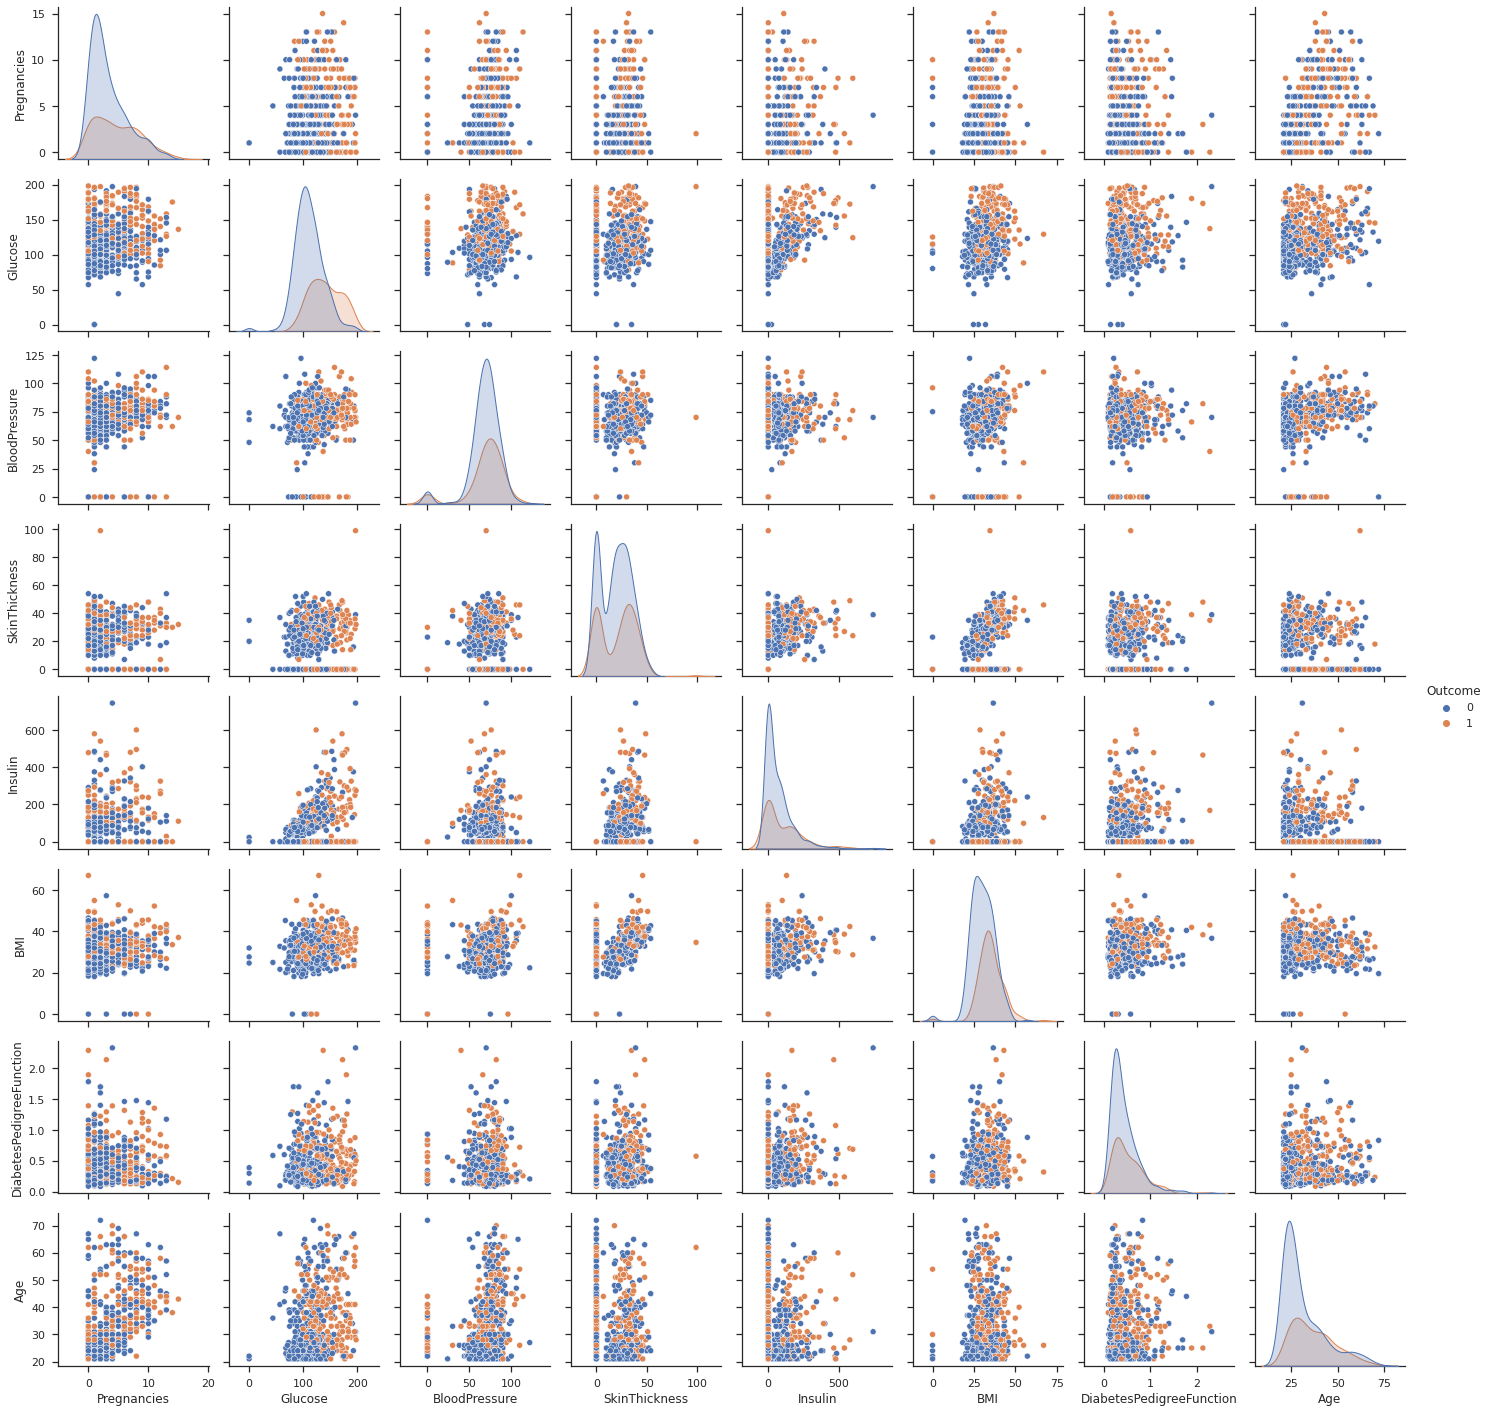

In [ ]:
sns.set_theme(style="ticks")
sns.pairplot(X_train.join(y_train), hue="Outcome");

By looking at the scatter plots of some features you can see some soft thresholds between features but nothing clear.

### Preprocess Data

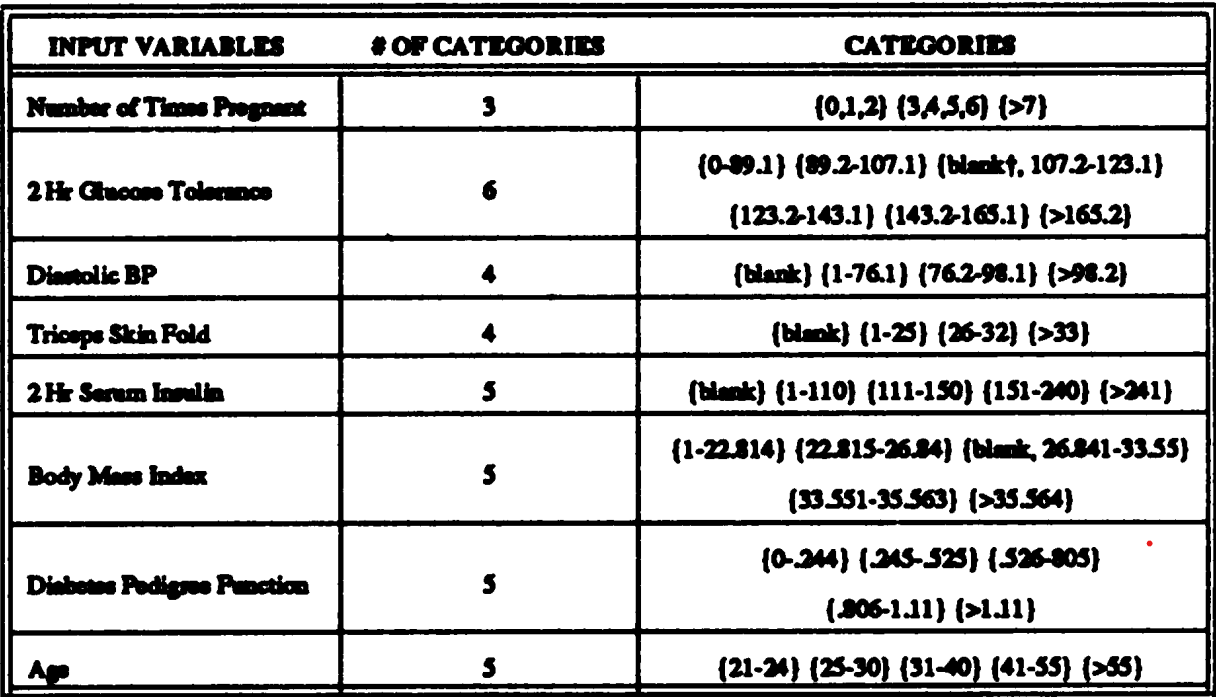
![Possible values for features](content/range_of_values.png)

As you can see from the table above (taken from the research paper) the features **"BloodPressure"**, **"SkinThickness"**, **"Insulin"** and **"BMI"** don't include **0** as a possible value. 
 
For that reason, I will consider them to be mistakes ("blanks") in the data.  
I will explore different solutions to overcome these "mistakes".


When looking at the previous table with the range of values for each feature. The value "Blank" appears as its own category for the features **"BloodPressure"**, **"SkinThickness"** and **"Insulin"**, for them I will impute an average for the missing values.**"BMI"** is slightly different since the "Blank" appears in the same category as values in the range of [26.841, 33.55], I will impute an average found within this range.

In [ ]:
possible_null_features = ["BloodPressure","SkinThickness","BMI", "Insulin"]

In [ ]:
X_train_copy = X_train.copy(deep = True)
X_test_copy = X_test.copy(deep = True)

X_train_copy[possible_null_features] = X_train_copy[possible_null_features].replace(0,np.NaN)
X_test_copy[possible_null_features] = X_test_copy[possible_null_features].replace(0,np.NaN)

In [ ]:
train_null_count = pd.DataFrame(X_train_copy.isnull().sum(),columns=["Train"])
test_null_count = pd.DataFrame(X_test_copy.isnull().sum(),columns=["Test"])

train_null_count.join(test_null_count)

Train  Test
Pregnancies                   0     0
Glucose                       0     0
BloodPressure                28     7
SkinThickness               179    48
Insulin                     290    84
BMI                           6     5
DiabetesPedigreeFunction      0     0
Age                           0     0

In [ ]:
print(f"{179/5.76:.2f}% of SkinThickness values are null")
print(f"{290/5.76:.2f}% of Insulin values are null")

31.08% of SkinThickness values are null
50.35% of Insulin values are null


Since there is a large quantity of “blank” values for the two features **SkinThickness** and 
**Insulin** I believe that my best option is to return the “Null” values to 0.   
I believe that there is too much missing information to try to impute the data. I also won’t drop the feature columns because according to the authors of the paper all 8 features are important for forecasting the target value.

### Impute Missing Values Using Averages

In [ ]:
index_map = {"mean":"Mean",
          "50%":"Median",
          0:"Mode",}

bmi_range = [26.841, 33.55] # The range of values that "Blank" is grouped with
X_train_dist = X_train_copy[["BMI"]].describe().loc[["mean","50%"]].append(X_train_copy.mode().iloc[0]).rename(index=index_map)

bmi_values = ((X_train_copy["BMI"] >= 26.841) & (X_train_copy["BMI"] <= 33.55))
bmi_averages = X_train_copy[["BMI"]][bmi_values].describe().loc[["mean","50%"]].append(X_train_copy[["BMI"]][bmi_values].mode().iloc[0]).rename(index=index_map)[["BMI"]]

X_train_dist = X_train_copy.describe().loc[["mean","50%"]].append(X_train_copy.mode().iloc[0]).rename(index=index_map)

X_train_dist["BMI"] = bmi_averages
X_train_dist[possible_null_features]

BloodPressure  SkinThickness      BMI     Insulin
Mean        72.315693      28.695214  30.3065  155.090909
Median      72.000000      29.000000  30.3000  125.500000
Mode        70.000000      32.000000  31.2000  120.000000

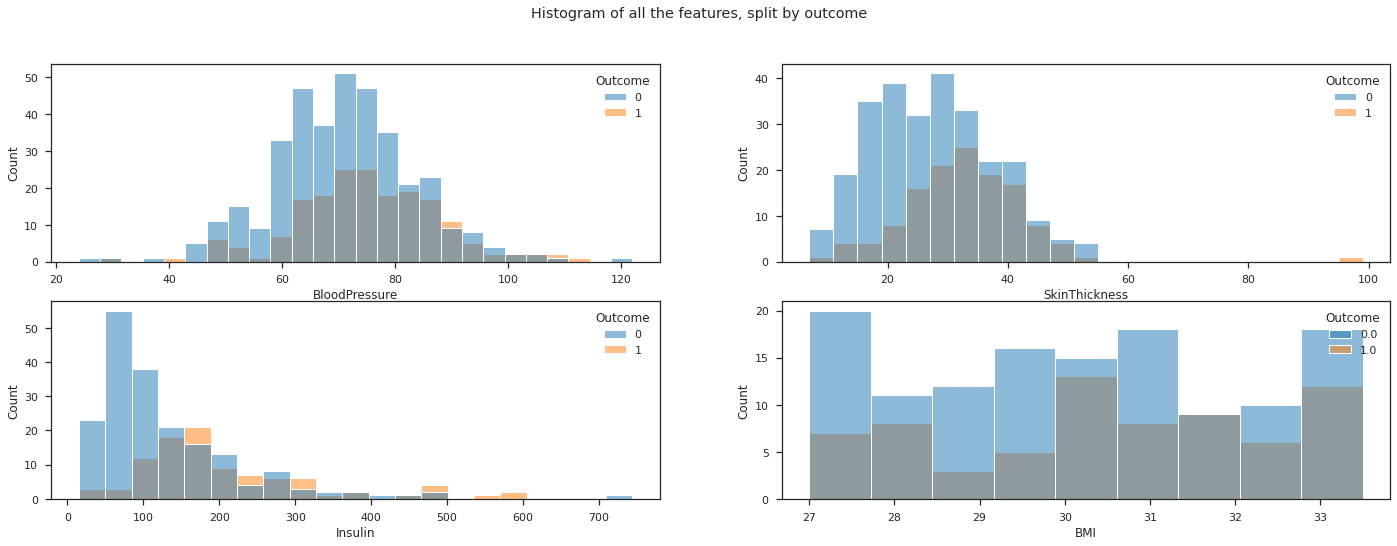

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(24, 8))

fig.suptitle("Histogram of all the features, split by outcome")

sns.histplot(ax=axes[0, 0], data=X_train_copy.join(y_train), x=X_train_copy["BloodPressure"], hue="Outcome", palette=color_palette)
sns.histplot(ax=axes[0, 1], data=X_train_copy.join(y_train), x=X_train_copy["SkinThickness"], hue="Outcome", palette=color_palette)
sns.histplot(ax=axes[1, 0], data=X_train_copy.join(y_train), x=X_train_copy["Insulin"], hue="Outcome", palette=color_palette)
sns.histplot(ax=axes[1, 1], data=X_train_copy.join(y_train)[bmi_values], x=X_train_copy["BMI"], hue="Outcome", palette=color_palette)

In [ ]:
print(X_train_copy[possible_null_features].drop(columns=["BMI"]).skew(axis = 0, skipna = True), end="\n\n")

print(X_train_copy[["BMI"]][bmi_values].skew(axis = 0, skipna = True))

BloodPressure    0.088814
SkinThickness    0.821843
Insulin          1.846382
dtype: float64

BMI   -0.04749
dtype: float64


In [ ]:
# I will use the mean for the features that follow similiar distributions to the normal distribution.

#Since the skew is less than 0.5 I will use the mean
avg_BloodPressure =  X_train_copy['BloodPressure'].mean()
avg_BMI =  X_train_copy["BMI"][bmi_values].mean() 

#Since the skew is greater than 0.5 I will use the median
avg_SkinThickness =  X_train_copy['SkinThickness'].median()
avg_Insulin =  X_train_copy['Insulin'].median()

# Save values to a dict to fill in nan values in the next cell, return SkinThickness and Insulin to 0
avg_dict = {"BloodPressure":avg_BloodPressure,
           "BMI":avg_BMI,
            "SkinThickness":0, 
            "Insulin":0
            }

In [ ]:
# Fill the NaN values using the average found using the train set
X_train_fillna_avg, X_test_fillna_avg = X_train_copy.copy(deep=True), X_test_copy.copy(deep=True)

for key, value in avg_dict.items():
  if key in possible_null_features:
    X_train_fillna_avg[key] = X_train_copy[key].fillna(value)
    X_test_fillna_avg[key] = X_test_copy[key].fillna(value)

In [ ]:
X_train_fillna_avg.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
118            4       97           60.0           23.0      0.0  28.2   
205            5      111           72.0           28.0      0.0  23.9   
506            0      180           90.0           26.0     90.0  36.5   
587            6      103           66.0            0.0      0.0  24.3   
34            10      122           78.0           31.0      0.0  27.6   

     DiabetesPedigreeFunction  Age  
118                     0.443   22  
205                     0.407   27  
506                     0.314   35  
587                     0.249   29  
34                      0.512   45

## Random Forest Classifier

In [ ]:
results_dict = {}
predicted_values = {}

#### Orginal Values no parameter tunning (Base case)

In [ ]:
rfc_model = RandomForestClassifier(random_state=random_state)

In [ ]:
best_model = find_best_model(X_train, y_train, False, rfc_model, {})

In [ ]:
pred_train, pred_test = find_and_print_results(X_train, X_test, y_train, y_test, best_model, return_results=True)

Train set results
Confusion matrix:
[[377   0]
 [  0 199]]

The accuracy score is: 1.00
The f1 score is: 1.00

Test set results
Confusion matrix:
[[110  13]
 [ 24  45]]

The accuracy score is: 0.81
The f1 score is: 0.71


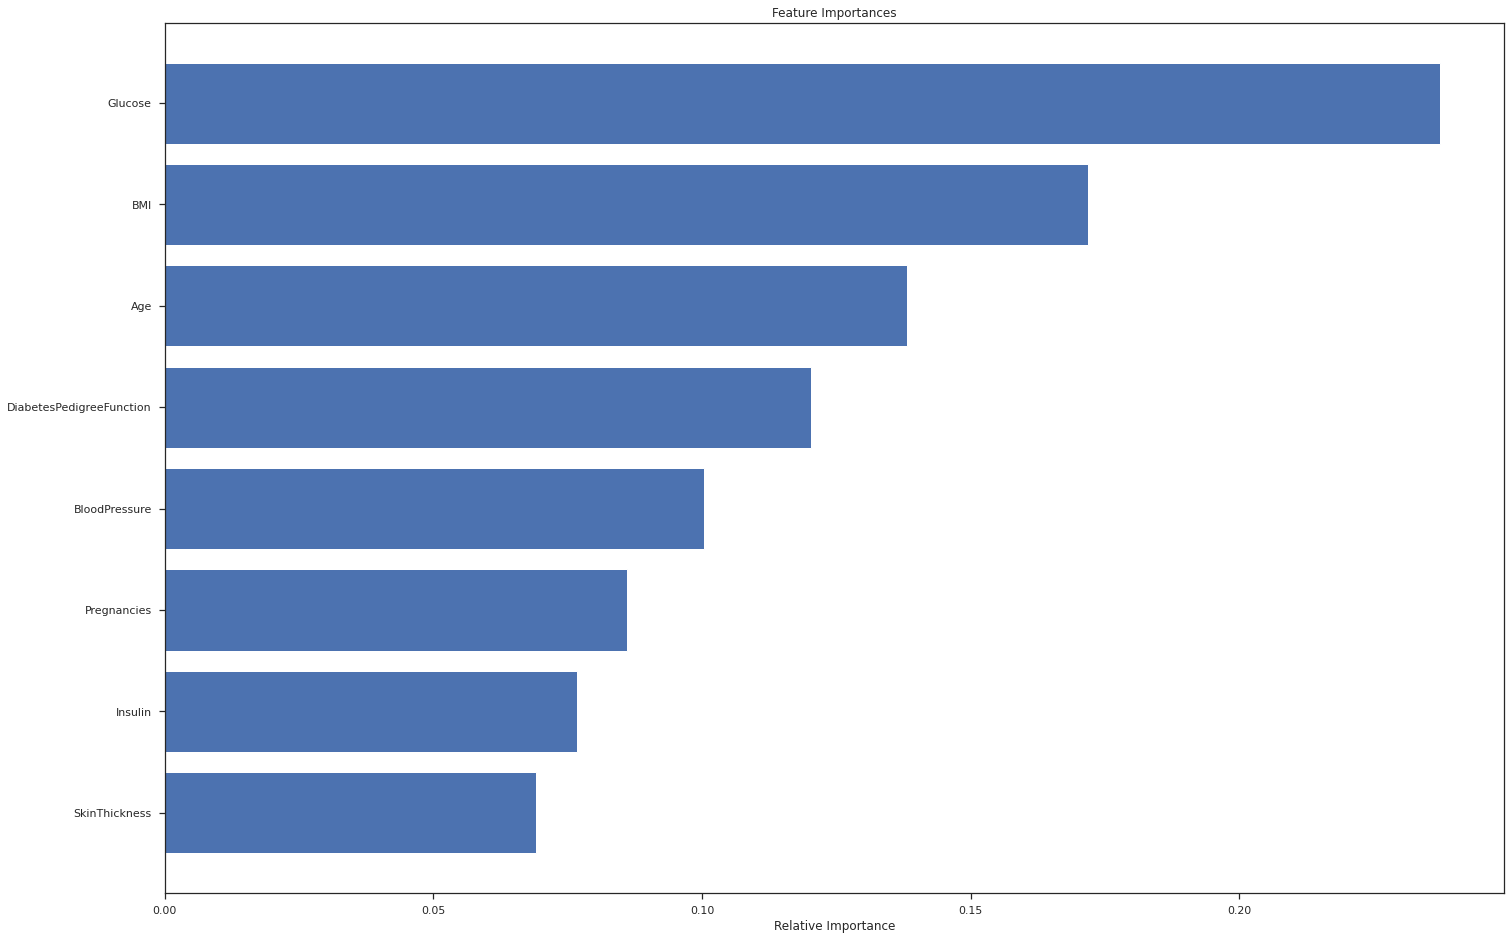

In [ ]:
results_dict["BaseCase"] = {"F1_train":1,"F1_test":0.71}
# A barplot of which features were the most important in the model.

colNames = X_train.columns
plot_feature_importances(colNames, best_model)

#### Orginal Values with parameter tunning 

In [ ]:
# Variables needed to find the best model
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# The parameters to tune using grid search
rfc_parameters = param_grid = { 
                'n_estimators': [10, 50, 100, 200, 500, 1000],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [i for i in range(2,12,2)],
                'criterion' :['gini', 'entropy']
                }

In [ ]:
best_model_og_1 = find_best_model(X_train, y_train, kf, rfc_model, rfc_parameters)

In [ ]:
pred_train_og_1, pred_test_og_1 = find_and_print_results(X_train, X_test, y_train, y_test, best_model_og_1, return_results=True)

Train set results
Confusion matrix:
[[377   0]
 [  1 198]]

The accuracy score is: 1.00
The f1 score is: 1.00

Test set results
Confusion matrix:
[[108  15]
 [ 21  48]]

The accuracy score is: 0.81
The f1 score is: 0.73


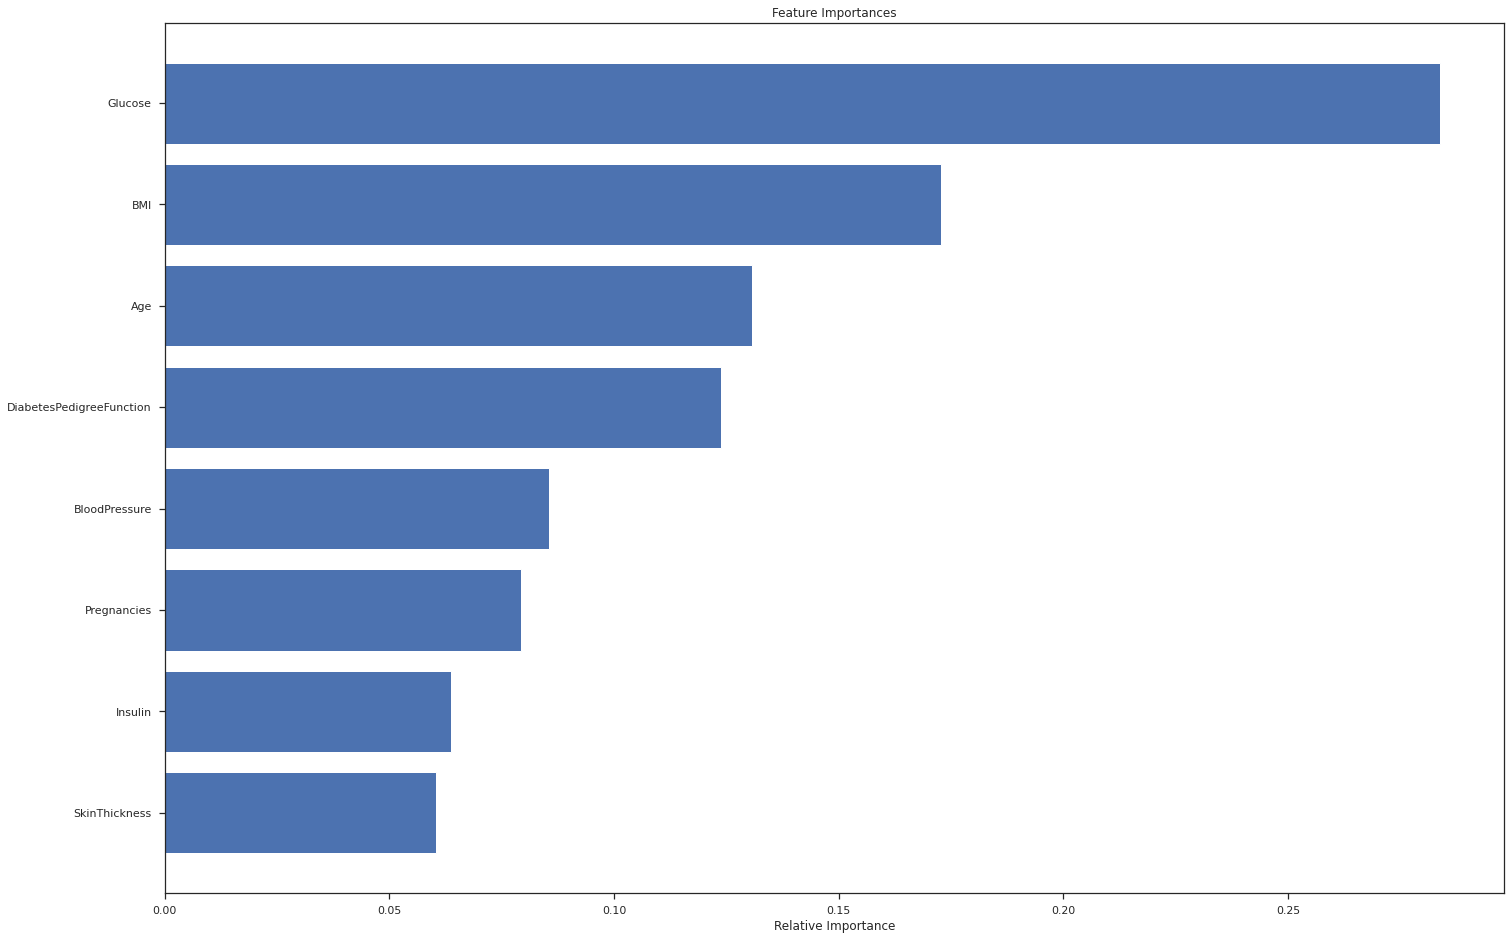

In [ ]:
results_dict["OrginalModel1"] = {"F1_train":1,"F1_test":0.73}

plot_feature_importances(colNames, best_model_og_1)

#### Imputed with Averages

In [ ]:
best_model_avg_1 = find_best_model(X_train_fillna_avg, y_train, kf, rfc_model, rfc_parameters)

In [ ]:
pred_train_avg_1, pred_test_avg_1 = find_and_print_results(X_train_fillna_avg, X_test_fillna_avg, y_train, y_test, best_model_avg_1, return_results=True)

Train set results
Confusion matrix:
[[377   0]
 [  1 198]]

The accuracy score is: 1.00
The f1 score is: 1.00

Test set results
Confusion matrix:
[[107  16]
 [ 22  47]]

The accuracy score is: 0.80
The f1 score is: 0.71


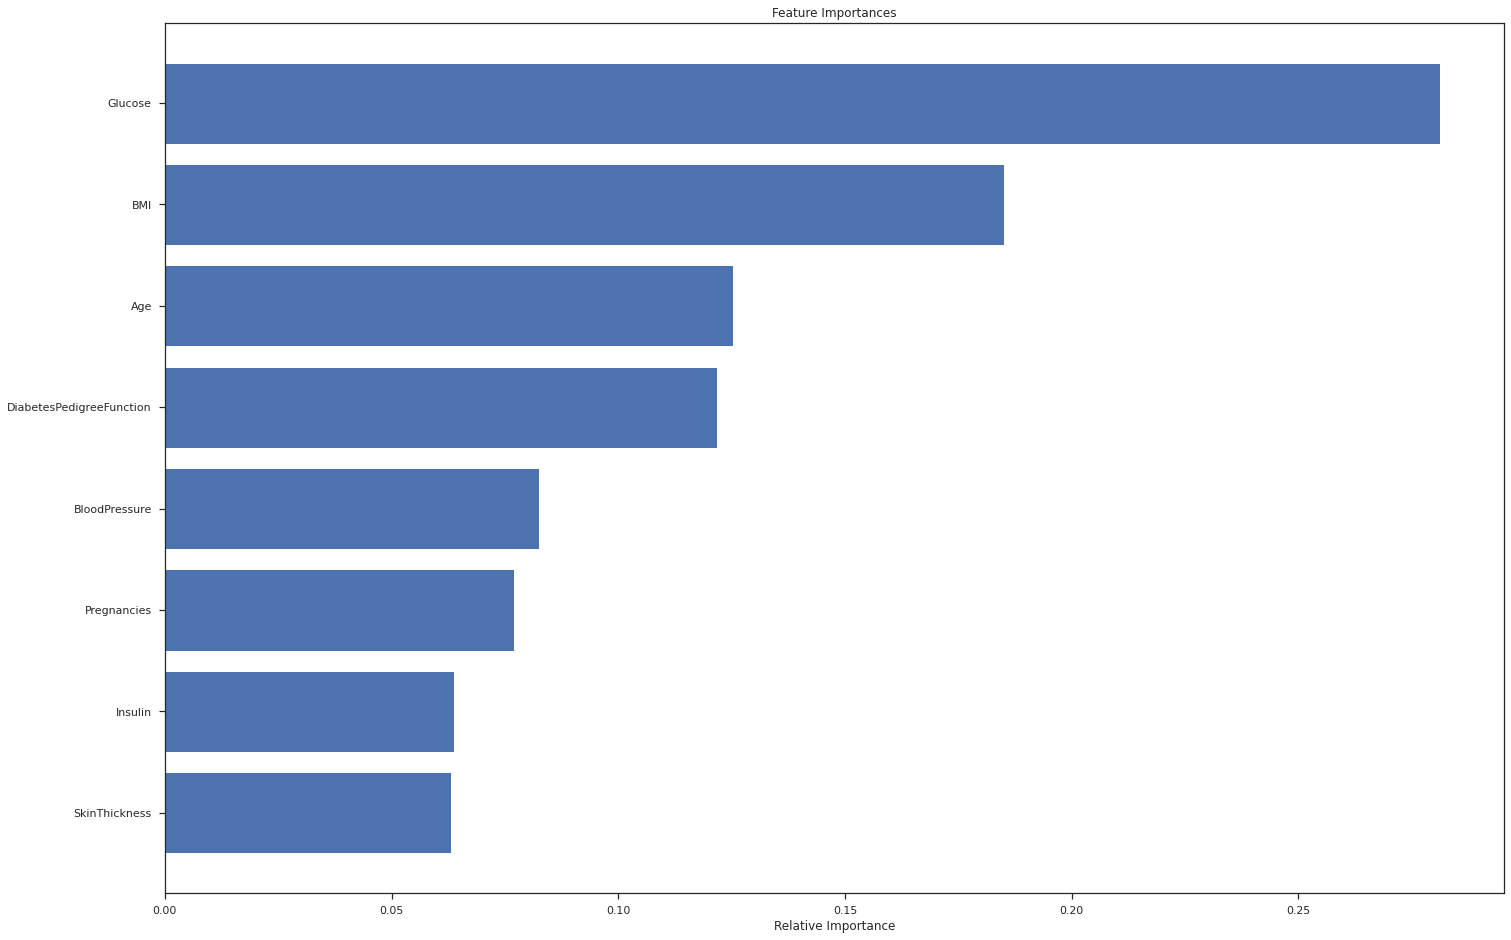

In [ ]:
results_dict["AvgImputedModel1"] = {"F1_train":1,"F1_test":0.72}

plot_feature_importances(X_train_fillna_avg.columns, best_model_avg_1)

## Automated ML method via PyCaret

For this assignment, I utilised PyCaret, which is an AutoML library. AutoML is short for Automated Machine learning, this is a tool which is designed to aid data scientists in areas such as model selection and hyperparameters tuning. PyCaret achieves this by providing a low-code machine learning workflow that compares many machine learning algorithms with only a few lines of code.
<br> </br>
**Example code**

```
from pycaret.classification import *
s = setup(data, target = 'Class variable')
best = compare_models(sort="F1")
```

As you can see with only three lines of code you can set up the PyCaret classification model and compare over 18 different algorithms sorted by a variety of metrics e.g. F1-Score. 

PyCaret is designed to work on a wide range of problems such as; classification, regression, clustering, time series analysis and anomaly detection. 
This assignment was a binary (will / will not develop diabetes) classification problem. 
For that reason, I only used the classification aspect of PyCaret. For future work, I would also like to look into the anomaly detection module and compare the results achieved with the full dataset and the dataset after the removal of anomalies.

<br> </br>
**How I used PyCaret**

First I took a similar approach to the **Example code** above. I started with the setup() function and included extra parameters that I didn’t include in the example. I ran this twice, first on the original dataset and then on the imputed dataset. Both times I compared the models sorted by the "F1-Score" using the compare_models() function.

So far I have only given details on the code but not on how it works.

The **setup()** function initializes the environment in PyCaret and creates the necessary pipeline for modelling and deployment. It also automatically infers the data type for each column and applies an initial pre-processing step to each column. In my case, it wrongly inferred the data type for the **Pregnancies** column as categorical instead of numerical. To fix this I passed in the parameter numeric_features  = ["Pregnancies"]. Similar to the code below.

```
s = setup(X_train, target = “Class variable”,  numeric_features  = ["Pregnancies"])
```
Another useful feature of this function is the automatic label encoder which is a necessary step as many algorithms need the data to be numeric.(i.e [“not diabetic”,”diabetic”] -> [0,1])

<br> </br>
Once the environment is set up and all features have been inferred correctly you can continue to the next step, **compare_models()**. This function is arguably the most impressive feature of the library. It quickly trains over 15 different algorithms and scores each of them using 7 different metrics and displays the results as an easy to read table. The metrics are calculated using the average result found by the cross-validation sets to avoid overfitting on the train set. 

<br> </br>
Running the code below will output only the best model found.

```
best = compare_models(sort="F1")
print(best)
```
This will print the algorithm along with the parameters for the model.

**Example Output**
```
GaussianNB(priors=None, var_smoothing=1e-09)
```
<br> </br>
Using the knowledge gained from the last step. I decided to further explore the GaussianNB model. I used the **create_mode()** and **tune_model()** functions. Similar to the previous functions these were quick and easy to use. As you can see in the example below.

**Example Code**
```
nb = create_model('nb', fold = 5)
tuned_nb = tune_model(nb, optimize = 'F1')
```

Now that I created and tuned the model it was time to compare the model to the results found using the **compare_models()** function. To do this I had to use the following functions **finalize_model()** and **predict_model()**. The **finalize_model()** function is used to fit the train set to the model (instead of cross-validation) and the **predict_model()** function takes in the finalized model and the features of the test set and predicates the target values.

**Example Code**
```
final_nb = finalize_model(tuned_nb)
prediction_test = predict_model(final_nb, data=X_test)
```
These are only a few of the features that PyCaret offer and in future work, I would like to explore and understand new ways to save time and improve the results of my models.

In [ ]:
""" 
These are the parameters I will use for the setup of the PyCaret model.

target: the value the features are trying to predict.
numeric_features:the Pregnancies column was being picked up as categorical.
session_id: same as random_state used through-out the notebook.
train_size: use the same train_size for the cross_validation.
normalize: some algorithms expect the data to be normalized
transformation: some algorithms expect the data to follow a normal distribution.
log_experiment: save info on the model.

"""
pyCaret_parameters = {
    "target" : "Outcome",  
    "numeric_features":["Pregnancies"],
    "session_id":random_state,
    "train_size":train_size,
    "normalize": True, 
    "transformation": True, 
    "log_experiment":True,
    "feature_selection": True,
}

compare_parameters = {"sort":"F1"}

Original data

In [ ]:
# initializes the environment in PyCaret 
clf_og_2 = setup(data = X_train.join(y_train), experiment_name = 'PyCaret_Orginal', **pyCaret_parameters)

# compare models
best_og_2 = compare_models(**compare_parameters)

Model  Accuracy     AUC  Recall   Prec.  \
lightgbm  Light Gradient Boosting Machine    0.7522  0.7829  0.6258  0.6551   
nb                            Naive Bayes    0.7405  0.8202  0.6062  0.6587   
rf               Random Forest Classifier    0.7498  0.8031  0.5796  0.6797   
ridge                    Ridge Classifier    0.7566  0.0000  0.5529  0.7110   
lr                    Logistic Regression    0.7543  0.8300  0.5529  0.7034   
lda          Linear Discriminant Analysis    0.7543  0.8283  0.5529  0.7034   
ada                  Ada Boost Classifier    0.7314  0.7823  0.5800  0.6364   
knn                K Neighbors Classifier    0.7288  0.7769  0.5596  0.6387   
gbc          Gradient Boosting Classifier    0.7383  0.7893  0.5400  0.6611   
qda       Quadratic Discriminant Analysis    0.7337  0.8001  0.5346  0.6692   
dt               Decision Tree Classifier    0.7035  0.6793  0.5988  0.5724   
et                 Extra Trees Classifier    0.7289  0.7983  0.5333  0.6361   
svm                   SVM - Linear Kernel    0.7200  0.0000  0.5417  0.6137   
dummy                    Dummy Classifier    0.6459  0.5000  0.0000  0.0000   

              F1   Kappa     MCC  TT (Sec)  
lightgbm  0.6365  0.4495  0.4526     0.130  
nb        0.6217  0.4271  0.4337     0.014  
rf        0.6168  0.4345  0.4431     0.515  
ridge     0.6123  0.4409  0.4540     0.019  
lr        0.6096  0.4362  0.4483     0.323  
lda       0.6096  0.4362  0.4483     0.020  
ada       0.6042  0.4019  0.4049     0.099  
knn       0.5899  0.3907  0.3965     0.117  
gbc       0.5893  0.4010  0.4086     0.103  
qda       0.5838  0.3932  0.4049     0.014  
dt        0.5824  0.3531  0.3559     0.020  
et        0.5756  0.3804  0.3857     0.551  
svm       0.5606  0.3621  0.3710     0.015  
dummy     0.0000  0.0000  0.0000     0.013

In [ ]:
evaluate_model(best_og_2)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

![feature_importance](imgs/feature_importance_01.png)

#### Imputed with Averages



In [ ]:
clf_avg_2 = setup(data =X_train_fillna_avg.join(y_train).reset_index(drop=True), experiment_name = 'PyCaret_Fillna_avg_01', **pyCaret_parameters)

# compare models
best_avg_2 = compare_models(**compare_parameters);

Model  Accuracy     AUC  Recall   Prec.  \
lr                    Logistic Regression    0.7566  0.8401  0.5658  0.6997   
nb                            Naive Bayes    0.7358  0.8283  0.6054  0.6407   
lda          Linear Discriminant Analysis    0.7543  0.8399  0.5658  0.6937   
ridge                    Ridge Classifier    0.7566  0.0000  0.5525  0.7045   
ada                  Ada Boost Classifier    0.7407  0.7729  0.5733  0.6652   
lightgbm  Light Gradient Boosting Machine    0.7267  0.7817  0.5988  0.6145   
qda       Quadratic Discriminant Analysis    0.7337  0.8060  0.5604  0.6494   
gbc          Gradient Boosting Classifier    0.7291  0.7863  0.5467  0.6507   
et                 Extra Trees Classifier    0.7406  0.7976  0.5333  0.6654   
knn                K Neighbors Classifier    0.7196  0.7791  0.5596  0.6175   
dt               Decision Tree Classifier    0.6968  0.6750  0.6008  0.5726   
rf               Random Forest Classifier    0.7359  0.8019  0.5271  0.6594   
svm                   SVM - Linear Kernel    0.6967  0.0000  0.5396  0.5785   
dummy                    Dummy Classifier    0.6459  0.5000  0.0000  0.0000   

              F1   Kappa     MCC  TT (Sec)  
lr        0.6176  0.4440  0.4538     0.017  
nb        0.6171  0.4166  0.4207     0.014  
lda       0.6151  0.4394  0.4487     0.015  
ridge     0.6113  0.4400  0.4509     0.013  
ada       0.6104  0.4181  0.4245     0.099  
lightgbm  0.6038  0.3958  0.3979     0.043  
qda       0.5913  0.3980  0.4068     0.014  
gbc       0.5873  0.3890  0.3965     0.101  
et        0.5857  0.4025  0.4108     0.459  
knn       0.5822  0.3731  0.3772     0.115  
dt        0.5818  0.3454  0.3488     0.015  
rf        0.5787  0.3922  0.4010     0.492  
svm       0.5449  0.3209  0.3290     0.014  
dummy     0.0000  0.0000  0.0000     0.013

In [ ]:
evaluate_model(best_avg_2)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

![feature_importance](imgs/feature_importance_02.png)

## Exploring Other Models


For this section, I will create and tune two separate algorithms using PyCaret.
1. Random Forests
2. Naive Bayes
 
I picked Random Forest as I wanted to compare the results to my hand-engineered models and I also picked Naive Bayes as this returned the best results in the previous section.

In the previous the orginal data outprefromed the imputed dataset, for this reason I will only use the orginal data for this section.

In [ ]:
s = setup(data = X_train.join(y_train), experiment_name = 'PyCaret_Orginal', **pyCaret_parameters)
rf = create_model('rf', fold = 5)

tuned_rf = tune_model(rf, optimize = 'F1', fold = 5)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.7931  0.8785  0.8065  0.6757  0.7353  0.5676  0.5736
1       0.6897  0.7627  0.5484  0.5667  0.5574  0.3185  0.3186
2       0.6395  0.7006  0.6667  0.4878  0.5634  0.2688  0.2783
3       0.7209  0.7976  0.7333  0.5789  0.6471  0.4215  0.4296
4       0.8140  0.8839  0.7097  0.7586  0.7333  0.5907  0.5915
Mean    0.7314  0.8046  0.6929  0.6135  0.6473  0.4334  0.4383
Std     0.0647  0.0698  0.0853  0.0939  0.0778  0.1290  0.1279

In [ ]:
y_train_tuned_rf = predict_model(tuned_rf, data=X_train)["Label"]
y_test_tuned_rf = predict_model(tuned_rf, data=X_test)["Label"]

print_results(y_train, y_train_tuned_rf, y_test, y_test_tuned_rf)

Train set results
Confusion matrix:
[[283  94]
 [ 31 168]]

The accuracy score is: 0.78
The f1 score is: 0.73

Test set results
Confusion matrix:
[[96 27]
 [10 59]]

The accuracy score is: 0.81
The f1 score is: 0.76


In [ ]:
results_dict["PyCaretRF"] = {"F1_train":0.73,"F1_test":0.76}

In [ ]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
nb = create_model('nb', fold = 5)

tuned_nb = tune_model(nb, optimize = 'F1',fold = 5)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8161  0.8785  0.6774  0.7778  0.7241  0.5872  0.5903
1       0.7011  0.7834  0.5806  0.5806  0.5806  0.3485  0.3485
2       0.6279  0.7036  0.5667  0.4722  0.5152  0.2173  0.2197
3       0.7674  0.8589  0.6000  0.6923  0.6429  0.4717  0.4744
4       0.7558  0.8674  0.5161  0.7273  0.6038  0.4346  0.4479
Mean    0.7337  0.8184  0.5882  0.6500  0.6133  0.4119  0.4162
Std     0.0643  0.0664  0.0526  0.1100  0.0692  0.1239  0.1248

In [ ]:
y_train_tuned_nb = predict_model(tuned_nb, data=X_train)["Label"]
y_test_tuned_nb = predict_model(tuned_nb, data=X_test)["Label"]

print_results(y_train, y_train_tuned_nb, y_test, y_test_tuned_nb)

Train set results
Confusion matrix:
[[306  71]
 [ 76 123]]

The accuracy score is: 0.74
The f1 score is: 0.63

Test set results
Confusion matrix:
[[103  20]
 [ 21  48]]

The accuracy score is: 0.79
The f1 score is: 0.70


In [ ]:
results_dict["PyCaretNB"] = {"F1_train":0.63,"F1_test":0.70}

### Ensemble 


Bagging

In [ ]:
bagging_rf = ensemble_model(rf, n_estimators=25, optimize="F1",fold=5)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.7931  0.8517  0.6774  0.7241  0.7000  0.5424  0.5431
1       0.6667  0.7788  0.2903  0.5625  0.3830  0.1853  0.2044
2       0.6977  0.7098  0.6000  0.5625  0.5806  0.3447  0.3451
3       0.7907  0.8417  0.6667  0.7143  0.6897  0.5320  0.5328
4       0.7791  0.8578  0.5484  0.7727  0.6415  0.4884  0.5034
Mean    0.7454  0.8079  0.5566  0.6672  0.5990  0.4186  0.4257
Std     0.0528  0.0566  0.1411  0.0878  0.1160  0.1363  0.1317

In [ ]:
y_train_bagging_rf = predict_model(bagging_rf, data=X_train)["Label"]
y_test_bagging_rf = predict_model(bagging_rf, data=X_test)["Label"]

print_results(y_train, y_train_bagging_rf, y_test, y_test_bagging_rf)

Train set results
Confusion matrix:
[[354  23]
 [ 23 176]]

The accuracy score is: 0.92
The f1 score is: 0.88

Test set results
Confusion matrix:
[[108  15]
 [ 22  47]]

The accuracy score is: 0.81
The f1 score is: 0.72


In [ ]:
results_dict["BaggingRF"] = {"F1_train":0.88,"F1_test":0.72}

Boosting

In [ ]:
boosted_rf = ensemble_model(rf, n_estimators=25, optimize="F1",fold=5,method="Boosting")

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.7931  0.8272  0.6774  0.7241  0.7000  0.5424  0.5431
1       0.6667  0.7543  0.2903  0.5625  0.3830  0.1853  0.2044
2       0.6977  0.7190  0.5667  0.5667  0.5667  0.3345  0.3345
3       0.7442  0.8187  0.6000  0.6429  0.6207  0.4281  0.4286
4       0.7674  0.8516  0.5806  0.7200  0.6429  0.4734  0.4794
Mean    0.7338  0.7942  0.5430  0.6432  0.5826  0.3927  0.3980
Std     0.0460  0.0494  0.1320  0.0705  0.1086  0.1237  0.1184

In [ ]:
y_train_boosted_rf = predict_model(boosted_rf, data=X_train)["Label"]
y_test_boosted_rf = predict_model(boosted_rf, data=X_test)["Label"]

print_results(y_train, y_train_boosted_rf, y_test, y_test_boosted_rf)

Train set results
Confusion matrix:
[[352  25]
 [ 17 182]]

The accuracy score is: 0.93
The f1 score is: 0.90

Test set results
Confusion matrix:
[[104  19]
 [ 19  50]]

The accuracy score is: 0.80
The f1 score is: 0.72


In [ ]:
results_dict["BostingRF"] = {"F1_train":0.90,"F1_test":0.72}

## Comparing Results

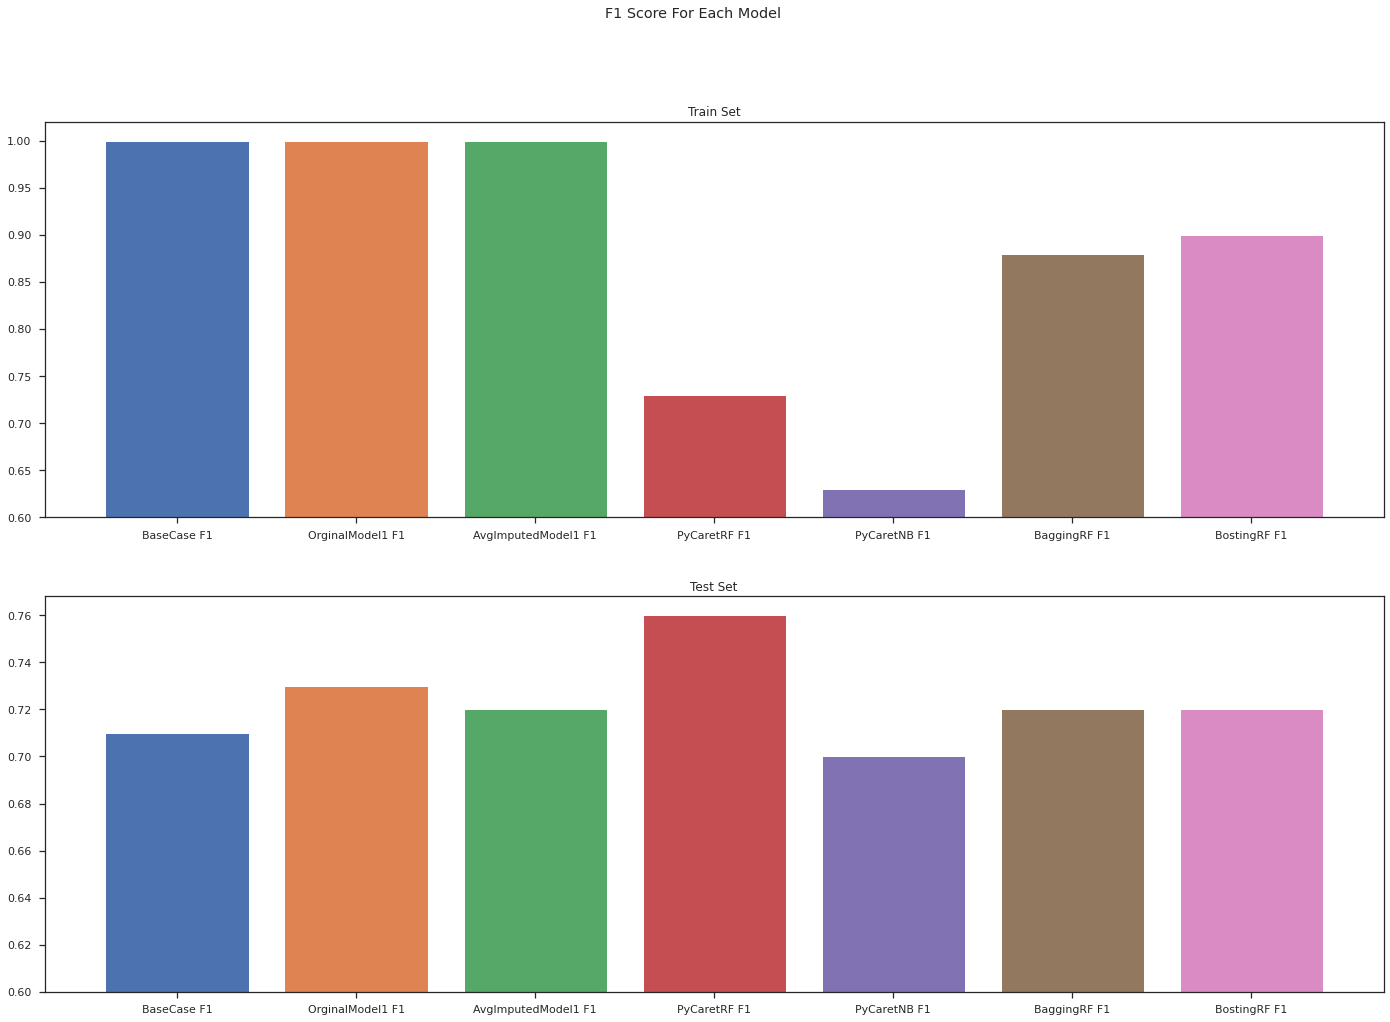

In [ ]:
results = pd.DataFrame(results_dict, columns=results_dict.keys())

fig, axes = plt.subplots(2, 1, figsize=(24, 16))

fig.suptitle("F1 Score For Each Model")
for col in results.columns:
  axes[0].bar(height = results[col]["F1_train"]-0.6, x= [f"{col} F1"], bottom=0.6)
  axes[1].bar(height = results[col]["F1_test"]-0.6, x= [f"{col} F1"], bottom=0.6)
axes[0].set_title('Train Set');
axes[1].set_title('Test Set');

In [92]:
results

BaseCase  OrginalModel1  AvgImputedModel1  PyCaretRF  PyCaretNB  \
F1_train      1.00           1.00              1.00       0.73       0.63   
F1_test       0.71           0.73              0.72       0.76       0.70   

          BaggingRF  BostingRF  
F1_train       0.88       0.90  
F1_test        0.72       0.72

## Results
 
For this assignment, I compared 7 different models using both Random Forests and Naive Bayes.   
6 of the models were trained using the Random Forests algorithm and 1 using Naive Bayes. 


#### Model description

| Model Name | With PyCaret |Trained on | Tunned Parameters|Algorithm |Test F1-Score|Train F1-Score|
| ----------- | ----------- | ----------- |------|------|------|-----|
| BaseCase|No| Train Set| No|RF|0.71|1.00|
| OrginalModel1|No| Cross-Validation(Train Set)|Yes(GridSearch)|RF|0.73|1.00|
| AvgImputedModel1|No| Cross-Validation(Train Set)|Yes(GridSearch)|RF|0.72|1.00|
| PyCaretRF|Yes|Cross-Validation(Train Set)|Yes(PyCaret)|RF|0.76|0.73|
| PyCaretNB|Yes|Cross-Validation(Train Set)|Yes(PyCaret)|NB|0.70|0.63|
| BaggingRF|Yes|Cross-Validation(Train Set)|Yes(PyCaret)|RF|0.72|0.88|
| BostingRF|Yes|Cross-Validation(Train Set)|Yes(PyCaret)|RF|0.72|0.90|

<br></br>
On average the PyCaret models slightly outperformed the hand engineered random forest with the mean F1-Scores being 0.725 and 0.72 respectfully.
If you exclude the Naive Bayes PyCaret model (worst prefroming model) the mean increase to 0.733.

### PyCaret vs Hand Engineered

There are a few reasons why I believe the PyCaret models performed better than the hand-engineered models. The main reason would be the built-in preprocessing that PyCaret applies to each column along with the extra parameters which I passed through the model. The most important addition would be the **feature_selection** parameter, this removes any features that are considered to have low importance for the model prediction. **Insulin** was the only feature to be removed by PyCaret, this is also one of the features which I consider removing due to the high level of “Blank” values.
By having a look at the table above you can see that the three hand-engineered models all achieved a perfect F1-Score on the train set but experienced a huge drop-off in performance on the test set in comparison to the models trained using PyCaret. This has led me to believe that I overfitted the models with the **find_best_model()** function I wrote.   

### Future Work

Though the PyCaret Random Forest model had the best performance on the test set, in future work I would like to use a statistical test to compare if the models are statistically different. So far in my conclusion, I haven’t discussed the 2 ensemble models (bagging and boosting) that I included. The main reason for this is due to the fact that I didn’t spend as much time as I would’ve liked to. In future work, I would like to explore and learn about how these models work. Even with the little knowledge I have, I was able to achieve  decent results which just goes to show how user-friendly and powerful PyCaret is. Other aspects of the PyCaret library that I would also like to explore are Anomaly detection and a deeper look into the built-in feature engineering available.  


